In [3]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "../utils/")
from data_loader import load_data
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
import pathlib

In [4]:
latent_dir = pathlib.Path("../2.train-VAE/results/latent_df.parquet").resolve()
latent_df = pd.read_parquet(latent_dir)
metadata_dir = pathlib.Path(".././0.data-download/data/metadata_df.parquet").resolve()
metadata_df = pd.read_parquet(metadata_dir)
data_dir = pathlib.Path("../0.data-download/data/").resolve()
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")
gsea_results_dir = pathlib.Path("../3.analysis/results/combined_gsea_results.parquet.gz").resolve()
gsea_results_df = pd.read_parquet(gsea_results_dir)
significant_gsea_dir = pathlib.Path("../3.analysis/results/significant_gsea_results.parquet.gz")
significant_gsea_df = pd.read_parquet(significant_gsea_dir)

In [5]:
# Creating categorized lists of sample IDs used in BVAE training
# note that 10 of the 912 used samples have Unknown Sex

ped_ids = metadata_df.query("AgeCategory == 'Pediatric'").ModelID.tolist()
adult_ids = metadata_df.query("AgeCategory == 'Adult'").ModelID.tolist()
male_ids = metadata_df.query("Sex == 'Male'").ModelID.tolist()
female_ids = metadata_df.query("Sex == 'Female'").ModelID.tolist()
ped_male_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Male'").ModelID.tolist()
adult_male_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Male'").ModelID.tolist()
ped_female_ids = metadata_df.query("AgeCategory == 'Pediatric'").query("Sex == 'Female'").ModelID.tolist()
adult_female_ids = metadata_df.query("AgeCategory == 'Adult'").query("Sex == 'Female'").ModelID.tolist()

In [6]:
# Generating latent dataframes for each category and dropping the id column to prep for t tests
def generate_latent_df(latent_df, category_ids):
    """
    Generate a latent DataFrame filtered by category IDs and drop the 'ModelID' column.

    Parameters:
    latent_df (pd.DataFrame): The original DataFrame containing latent variables.
    category_ids (list): The list of ModelIDs to filter the DataFrame by.

    Returns:
    pd.DataFrame: The filtered DataFrame with the 'ModelID' column dropped.
    """
    filtered_df = latent_df[latent_df['ModelID'].isin(category_ids)].copy()
    filtered_df_float = filtered_df.drop(columns=["ModelID"])
    filtered_df_float.reset_index(drop=True, inplace=True)
    return filtered_df, filtered_df_float


# Usage for each category
adult_latent_df, adult_latent_df_float = generate_latent_df(latent_df, adult_ids)
ped_latent_df, ped_latent_df_float = generate_latent_df(latent_df, ped_ids)
male_latent_df, male_latent_df_float = generate_latent_df(latent_df, male_ids)
female_latent_df, female_latent_df_float = generate_latent_df(latent_df, female_ids)
ped_male_latent_df, ped_male_latent_df_float = generate_latent_df(latent_df, ped_male_ids)
adult_male_latent_df, adult_male_latent_df_float = generate_latent_df(latent_df, adult_male_ids)
ped_female_latent_df, ped_female_latent_df_float = generate_latent_df(latent_df, ped_female_ids)
adult_female_latent_df, adult_female_latent_df_float = generate_latent_df(latent_df, adult_female_ids)

In [7]:
# t tests comparing adult vs ped for each latent dimension

t_test_adult_vs_ped = ttest_ind(adult_latent_df_float, ped_latent_df_float)
t_test_adult_vs_ped = pd.DataFrame(t_test_adult_vs_ped).T
t_test_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
t_test_adult_vs_ped['latent_feature'] = t_test_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_adult_vs_ped = t_test_adult_vs_ped.dropna()
print(t_test_adult_vs_ped.shape)

t_test_adult_vs_ped.head(50)

(33, 4)


,t_stat,p_value,comparison,latent_feature
0,-3.218127,1.333718e-03,Adult vs Pediatric,1
2,-5.107409,3.941735e-07,Adult vs Pediatric,3
3,2.121312,3.415234e-02,Adult vs Pediatric,4
4,-2.344316,1.926592e-02,Adult vs Pediatric,5
5,1.278132,2.015132e-01,Adult vs Pediatric,6
6,0.418699,6.755301e-01,Adult vs Pediatric,7
7,0.418699,6.755301e-01,Adult vs Pediatric,8
8,1.033402,3.016773e-01,Adult vs Pediatric,9
9,0.418699,6.755302e-01,Adult vs Pediatric,10
10,0.418699,6.755301e-01,Adult vs Pediatric,11


In [8]:
# t tests comparing male vs female for each latent dimension

t_test_male_vs_female = ttest_ind(male_latent_df_float, female_latent_df_float)
t_test_male_vs_female = pd.DataFrame(t_test_male_vs_female).T
t_test_male_vs_female.columns = ["t_stat", "p_value"]
t_test_male_vs_female['comparison'] = 'Male vs Female'
t_test_male_vs_female['latent_feature'] = t_test_male_vs_female.index + 1
# Remove rows with NaN values
t_test_male_vs_female = t_test_male_vs_female.dropna()
print(t_test_male_vs_female.shape)

t_test_male_vs_female.head()

(33, 4)


,t_stat,p_value,comparison,latent_feature
0,1.512374,0.130773,Male vs Female,1
2,1.730208,0.083919,Male vs Female,3
3,0.090873,0.927613,Male vs Female,4
4,1.416794,0.156872,Male vs Female,5
5,0.349296,0.726945,Male vs Female,6


In [9]:
# t tests comparing adult male vs ped male for each latent dimension

t_test_adult_male_vs_ped_male = ttest_ind(ped_male_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_ped_male = pd.DataFrame(t_test_adult_male_vs_ped_male).T
t_test_adult_male_vs_ped_male.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_ped_male['comparison'] = 'Adult Male vs Pediatric Male'
t_test_adult_male_vs_ped_male['latent_feature'] = t_test_adult_male_vs_ped_male.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_ped_male = t_test_adult_male_vs_ped_male.dropna()
print(t_test_adult_male_vs_ped_male.shape)

t_test_adult_male_vs_ped_male.head()

(31, 4)


,t_stat,p_value,comparison,latent_feature
0,1.801326,0.072211,Adult Male vs Pediatric Male,1
2,3.084566,0.002143,Adult Male vs Pediatric Male,3
3,-1.600661,0.110039,Adult Male vs Pediatric Male,4
4,1.170902,0.242156,Adult Male vs Pediatric Male,5
5,-0.595032,0.552072,Adult Male vs Pediatric Male,6


In [10]:
# t tests comparing adult female vs ped female for each latent dimension

t_test_adult_female_vs_ped_female = ttest_ind(ped_female_latent_df_float, adult_female_latent_df_float)
t_test_adult_female_vs_ped_female = pd.DataFrame(t_test_adult_female_vs_ped_female).T
t_test_adult_female_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_adult_female_vs_ped_female['comparison'] = 'Adult Female vs Pediatric Female'
t_test_adult_female_vs_ped_female['latent_feature'] = t_test_adult_female_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_adult_female_vs_ped_female = t_test_adult_female_vs_ped_female.dropna()
print(t_test_adult_female_vs_ped_female.shape)

t_test_adult_female_vs_ped_female.head()

(29, 4)


,t_stat,p_value,comparison,latent_feature
0,2.826528,0.004938,Adult Female vs Pediatric Female,1
2,4.123023,0.000045,Adult Female vs Pediatric Female,3
3,-1.147304,0.251932,Adult Female vs Pediatric Female,4
4,2.252685,0.024812,Adult Female vs Pediatric Female,5
5,-1.150781,0.250500,Adult Female vs Pediatric Female,6


In [11]:
# t tests comparing ped male vs ped female for each latent dimension

t_test_ped_male_vs_ped_female = ttest_ind(ped_female_latent_df_float, ped_male_latent_df_float)
t_test_ped_male_vs_ped_female = pd.DataFrame(t_test_ped_male_vs_ped_female).T
t_test_ped_male_vs_ped_female.columns = ["t_stat", "p_value"]
t_test_ped_male_vs_ped_female['comparison'] = 'Pediatric Male vs Pediatric Female'
t_test_ped_male_vs_ped_female['latent_feature'] = t_test_ped_male_vs_ped_female.index + 1
# Remove rows with NaN values
t_test_ped_male_vs_ped_female = t_test_ped_male_vs_ped_female.dropna()
print(t_test_ped_male_vs_ped_female.shape)

t_test_ped_male_vs_ped_female.head()

(25, 4)


,t_stat,p_value,comparison,latent_feature
0,0.173129,0.862813,Pediatric Male vs Pediatric Female,1
2,0.478101,0.633363,Pediatric Male vs Pediatric Female,3
3,0.175723,0.860779,Pediatric Male vs Pediatric Female,4
4,0.373064,0.709695,Pediatric Male vs Pediatric Female,5
5,-0.889634,0.375269,Pediatric Male vs Pediatric Female,6


In [12]:
# t tests comparing adult male vs adult female for each latent dimension

t_test_adult_male_vs_adult_female = ttest_ind(adult_female_latent_df_float, adult_male_latent_df_float)
t_test_adult_male_vs_adult_female = pd.DataFrame(t_test_adult_male_vs_adult_female).T
t_test_adult_male_vs_adult_female.columns = ["t_stat", "p_value"]
t_test_adult_male_vs_adult_female['comparison'] = 'Adult Male vs Adult Female'
t_test_adult_male_vs_adult_female['latent_feature'] = t_test_adult_male_vs_adult_female.index + 1
# Remove rows with NaN values
t_test_adult_male_vs_adult_female = t_test_adult_male_vs_adult_female.dropna()
print(t_test_adult_male_vs_adult_female.shape)

t_test_adult_male_vs_adult_female.head()

(33, 4)


,t_stat,p_value,comparison,latent_feature
0,-1.734332,0.083239,Adult Male vs Adult Female,1
2,-2.009238,0.044843,Adult Male vs Adult Female,3
3,-0.176256,0.860137,Adult Male vs Adult Female,4
4,-1.646554,0.100037,Adult Male vs Adult Female,5
5,-0.133334,0.893963,Adult Male vs Adult Female,6


In [13]:
# Combining and saving t test results
t_test_results_df = pd.concat([
    t_test_adult_vs_ped, 
    t_test_male_vs_female, 
    t_test_adult_male_vs_ped_male, 
    t_test_adult_female_vs_ped_female, 
    t_test_ped_male_vs_ped_female, 
    t_test_adult_male_vs_adult_female
]).reset_index(drop=True)
t_test_results_dir = pathlib.Path("./results/t_test_results.tsv")
t_test_results_df.to_parquet(t_test_results_dir)

# sort to show most significant p-values
t_test_results_df.sort_values(by='p_value', ascending = True)

,t_stat,p_value,comparison,latent_feature
13,-9.486921,1.827865e-20,Adult vs Pediatric,15
18,-8.084050,1.884506e-15,Adult vs Pediatric,20
106,7.336605,1.201889e-12,Adult Female vs Pediatric Female,15
23,-6.820863,1.603158e-11,Adult vs Pediatric,25
19,-6.600415,6.785679e-11,Adult vs Pediatric,21
...,...,...,...,...
140,0.122658,9.025627e-01,Pediatric Male vs Pediatric Female,23
35,0.090873,9.276128e-01,Male vs Female,4
64,0.084749,9.324789e-01,Male vs Female,35
138,0.080982,9.355782e-01,Pediatric Male vs Pediatric Female,20


In [14]:
# ANOVA Testing
f_statistic, p_value = f_oneway(adult_male_latent_df_float, ped_male_latent_df_float, adult_female_latent_df_float, ped_female_latent_df_float)
anova_df = pd.DataFrame({'f_stat': f_statistic.tolist(), 'p_value': p_value.tolist()})
anova_df['latent_feature'] = anova_df.index + 1
# Remove rows with NaN values
anova_df = anova_df.dropna()
anova_df

/home/juliacurd/anaconda3/envs/gene_dependency_representations/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:605: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


,f_stat,p_value,latent_feature
0,4.304991,5.009211e-03,1
2,9.917823,1.927772e-06,3
3,1.305123,2.714218e-01,4
4,2.819108,3.801336e-02,5
5,0.622503,6.005391e-01,6
6,0.351409,7.881409e-01,7
7,0.351410,7.881405e-01,8
8,2.375147,6.870333e-02,9
9,0.563613,6.391101e-01,10
10,0.351410,7.881407e-01,11


In [15]:
#Lung cancer in adults vs neuroblastoma in peds comparison

# Extract Neuroblastoma model IDs from the model dataframe
NB_ids = model_df.query("OncotreePrimaryDisease == 'Neuroblastoma'").ModelID.tolist()

# Create a copy of the pediatric latent space dataframe
ped_NB_latent_df = ped_latent_df.copy()

# Filter the pediatric latent dataframe to include only Neuroblastoma models
for index, row in ped_NB_latent_df.iterrows():
    if row['ModelID'] not in NB_ids:
        ped_NB_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered pediatric latent dataframe
# and reset the index
ped_NB_latent_float_df = ped_NB_latent_df.drop(columns=["ModelID"])
ped_NB_latent_float_df.reset_index(drop=True, inplace=True)

# Extract Non-Small Cell Lung Cancer (NSCLC) model IDs from the model dataframe
LC_ids = model_df.query("OncotreePrimaryDisease == 'Non-Small Cell Lung Cancer'").ModelID.tolist()

# Create a copy of the adult latent space dataframe
adult_LC_latent_df = adult_latent_df.copy()

# Filter the adult latent dataframe to include only NSCLC models
for index, row in adult_LC_latent_df.iterrows():
    if row['ModelID'] not in LC_ids:
        adult_LC_latent_df.drop(index, inplace=True)

# Drop the 'ModelID' column from the filtered adult latent dataframe
# and reset the index
adult_LC_latent_float_df = adult_LC_latent_df.drop(columns=["ModelID"])
adult_LC_latent_float_df.reset_index(drop=True, inplace=True)

In [16]:
# t tests comparing Lung Cancer in adult vs Neuroblastoma in ped for each latent dimension

t_test_diff_adult_vs_ped = ttest_ind(adult_LC_latent_float_df, ped_NB_latent_float_df)
t_test_diff_adult_vs_ped = pd.DataFrame(t_test_diff_adult_vs_ped).T
t_test_diff_adult_vs_ped.columns = ["t_stat", "p_value"]
t_test_diff_adult_vs_ped['comparison'] = 'Lung Cancer vs Neuroblastoma'
t_test_diff_adult_vs_ped['latent_feature'] = t_test_diff_adult_vs_ped.index + 1
# Remove rows with NaN values
t_test_diff_adult_vs_ped = t_test_diff_adult_vs_ped.dropna()
print(t_test_diff_adult_vs_ped.shape)

t_test_diff_adult_vs_ped.sort_values(by = 'p_value', ascending= True)

(24, 4)


,t_stat,p_value,comparison,latent_feature
14,-9.156894,2.724268e-15,Lung Cancer vs Neuroblastoma,15
19,-7.072663,1.348224e-10,Lung Cancer vs Neuroblastoma,20
24,-5.599585,1.528553e-07,Lung Cancer vs Neuroblastoma,25
15,-5.462841,2.822401e-07,Lung Cancer vs Neuroblastoma,16
29,-5.404335,3.660317e-07,Lung Cancer vs Neuroblastoma,30
32,-4.977234,2.330309e-06,Lung Cancer vs Neuroblastoma,33
20,-4.970053,2.402213e-06,Lung Cancer vs Neuroblastoma,21
33,-4.749113,6.042632e-06,Lung Cancer vs Neuroblastoma,34
31,-3.962528,1.302539e-04,Lung Cancer vs Neuroblastoma,32
2,-3.958313,1.322873e-04,Lung Cancer vs Neuroblastoma,3


In [17]:
# Obtaining shared cancer types in ped and adult
adult_types = model_df.query("AgeCategory == 'Adult'").OncotreePrimaryDisease.tolist()
adult_types = [x for x in adult_types if adult_types.count(x) >= 5]
adult_types = list(set(adult_types))

ped_types = model_df.query("AgeCategory == 'Pediatric'").OncotreePrimaryDisease.tolist()
ped_types = [x for x in ped_types if ped_types.count(x) >= 5]
ped_types = list(set(ped_types))

all_types = set(adult_types) | set(ped_types)

shared_types = set(adult_types) & set(ped_types)
shared_types

{'Acute Myeloid Leukemia', 'Ewing Sarcoma', 'Mature B-Cell Neoplasms'}

In [18]:
# Comparing the shared cancer types
# Initialize a list to store the t-test results for each shared cancer type
comp_dfs = []

# Iterate over each cancer type shared between adult and pediatric datasets
for cancer_type in shared_types:
    # Extract the model IDs for the current cancer type from the model dataframe
    type_ids = model_df.query("OncotreePrimaryDisease == " + "'" + cancer_type + "'").ModelID.tolist()

    # Filter the pediatric latent dataframe to include only models of the current cancer type
    ped_type_latent_df = ped_latent_df.copy()
    ped_type_latent_df = ped_latent_df[ped_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the pediatric latent dataframe
    ped_type_latent_float_df = ped_type_latent_df.drop(columns=["ModelID"])
    ped_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Filter the adult latent dataframe to include only models of the current cancer type
    adult_type_latent_df = adult_latent_df.copy()
    adult_type_latent_df = adult_latent_df[adult_latent_df['ModelID'].isin(type_ids)].copy()

    # Drop the 'ModelID' column and reset the index in the adult latent dataframe
    adult_type_latent_float_df = adult_type_latent_df.drop(columns=["ModelID"])
    adult_type_latent_float_df.reset_index(drop=True, inplace=True)

    # Perform a t-test comparing the latent features between adult and pediatric datasets
    t_test_type_adult_vs_ped = ttest_ind(adult_type_latent_float_df, ped_type_latent_float_df)

    # Convert the t-test results to a DataFrame and add additional information
    t_test_type_adult_vs_ped = pd.DataFrame(t_test_type_adult_vs_ped).T
    t_test_type_adult_vs_ped.columns = ["t_stat", "p_value"]
    t_test_type_adult_vs_ped['comparison'] = 'Adult vs Pediatric'
    t_test_type_adult_vs_ped['cancer_type'] = cancer_type
    t_test_type_adult_vs_ped['latent_feature'] = t_test_type_adult_vs_ped.index + 1

    # Append the t-test results for the current cancer type to the list
    comp_dfs.append(t_test_type_adult_vs_ped)

# Concatenate all the t-test results into a single DataFrame
t_test_type_results_df = pd.concat(comp_dfs).reset_index(drop=True)

# Remove any rows with NaN values from the results
t_test_type_results_df = t_test_type_results_df.dropna()

# Sort the t-test results by the p-value in ascending order
t_test_type_results_df.sort_values(by='p_value', ascending=True)

,t_stat,p_value,comparison,cancer_type,latent_feature
101,1.939462,0.064287,Adult vs Pediatric,Acute Myeloid Leukemia,30
99,1.933352,0.065073,Adult vs Pediatric,Acute Myeloid Leukemia,28
103,1.477448,0.152559,Adult vs Pediatric,Acute Myeloid Leukemia,32
15,1.338527,0.195037,Adult vs Pediatric,Ewing Sarcoma,16
74,1.330467,0.195869,Adult vs Pediatric,Acute Myeloid Leukemia,3
...,...,...,...,...,...
62,-0.113085,0.910434,Adult vs Pediatric,Mature B-Cell Neoplasms,27
107,0.106392,0.916156,Adult vs Pediatric,Acute Myeloid Leukemia,36
52,-0.027256,0.978369,Adult vs Pediatric,Mature B-Cell Neoplasms,17
4,-0.008869,0.993007,Adult vs Pediatric,Ewing Sarcoma,5


In [19]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Add "z_" prefix to the latent dimensions in the t-test DataFrame
t_test_adult_vs_ped['z_dim'] = 'z_' + t_test_adult_vs_ped['latent_feature'].astype(str)
t_test_adult_vs_ped['group'] = t_test_adult_vs_ped['t_stat'].apply(lambda x: 'Adult' if x > 0 else 'Pediatric')

# Filter significant latent features
significant_latent_features = t_test_adult_vs_ped[t_test_adult_vs_ped['p_value'] < 0.05]

# Add the 'z_dim' column if not already added
significant_latent_features.loc[:, 'z_dim'] = 'z_' + significant_latent_features['latent_feature'].astype(str)


# Loop through all unique pathways (Terms) in the GSEA DataFrame
for pathway in gsea_results_df['Term'].unique():
    # Filter for the pathway
    filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
    
    # Further filter by significant latent features
    filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
    
    # Merge GSEA DataFrame with t-test DataFrame to get group information
    merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')

    # Group by 'group' and collect ES values
    grouped_data = merged_df.groupby('group')['es'].apply(list)

    # Ensure we have data for both groups
    if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*grouped_data)

        # Determine which group has higher enrichment score
        adult_mean = np.mean(grouped_data['Adult'])
        pediatric_mean = np.mean(grouped_data['Pediatric'])
        higher_group = 'Adult' if adult_mean > pediatric_mean else 'Pediatric'

        # Store results
        anova_results.append({
            'Pathway': pathway,
            'F-statistic': f_statistic,
            'p-value': p_value,
            'Higher in': higher_group
        })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

anova_dir = pathlib.Path("./results/anova_results.csv")
significant_anova_results_df.to_csv(anova_dir)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending = False).head(50)

,Pathway,F-statistic,p-value,Higher in
222,Metabolism R-HSA-1430728,14.444604,0.000482,Adult
31,Chaperonin-mediated Protein Folding R-HSA-390466,9.192164,0.004251,Pediatric
0,Metabolism Of Nucleotides R-HSA-15869,9.002977,0.004624,Adult
723,Mitochondrial Translation Termination R-HSA-54...,8.652187,0.005410,Adult
451,Gluconeogenesis R-HSA-70263,8.275562,0.006415,Adult
247,Post-translational Protein Phosphorylation R-H...,8.155295,0.006776,Pediatric
248,Regulation Of IGF Transport And Uptake By IGFB...,8.155295,0.006776,Pediatric
49,Metabolism Of Porphyrins R-HSA-189445,8.024915,0.007193,Adult
50,Heme Biosynthesis R-HSA-189451,8.024914,0.007193,Adult
147,Cooperation Of PDCL (PhLP1) And TRiC/CCT In G-...,7.778841,0.008055,Pediatric


/tmp/ipykernel_3697599/2057681926.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)


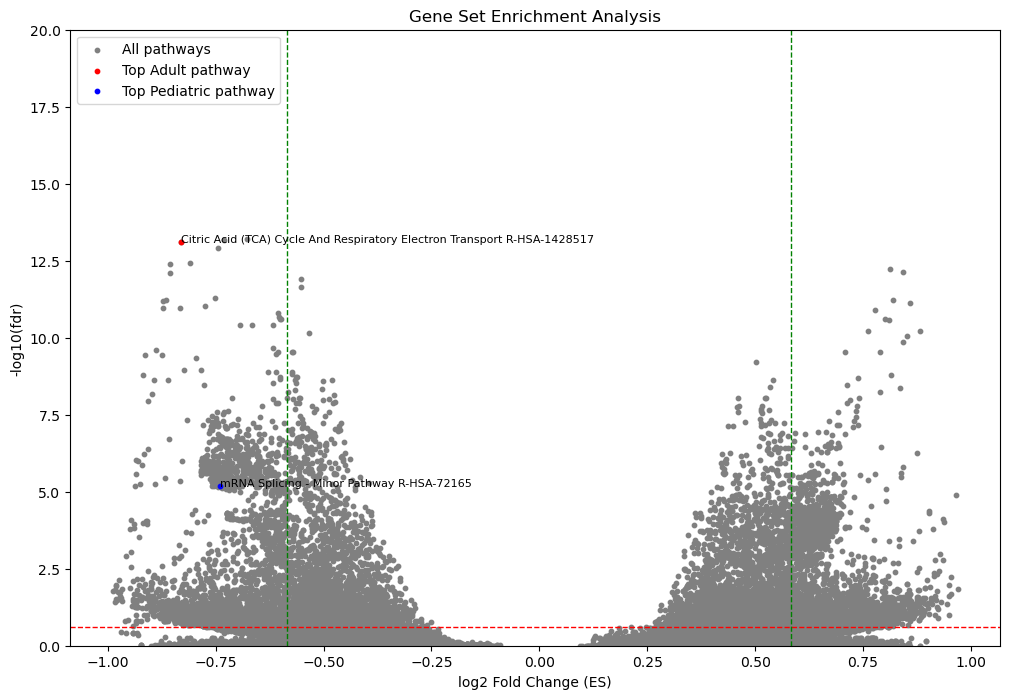

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define cut-offs
lfc_cutoff = 0.584
fdr_cutoff = 0.25

# Merge GSEA results with ANOVA results based on the 'Pathway' column
significant_anova_results_df.rename(columns={'Pathway': 'Term'}, inplace=True)
merged_df = significant_gsea_df.merge(significant_anova_results_df[['Term', 'Higher in', 'F-statistic']], on='Term', how='left')

# Define masks for adult and pediatric pathways
adult_mask = merged_df['Higher in'] == 'Adult'
pediatric_mask = merged_df['Higher in'] == 'Pediatric'

# Sort by the absolute value of NES and select the top 5 adult and top 5 pediatric pathways
top_adult = merged_df[adult_mask].loc[merged_df[adult_mask]['nes'].abs().nlargest(1).index]
top_pediatric = merged_df[pediatric_mask].loc[merged_df[pediatric_mask]['nes'].abs().nlargest(1).index]

# Combine the top pathways
top_pathways_df = pd.concat([top_adult, top_pediatric])

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all pathways in grey
plt.scatter(x=gsea_results_df['es'], 
            y=gsea_results_df['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='grey', label='All pathways')

# Plot top adult pathways in red
plt.scatter(x=top_adult['es'], 
            y=top_adult['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='red', label='Top Adult pathway')

# Plot top pediatric pathways in blue
plt.scatter(x=top_pediatric['es'], 
            y=top_pediatric['fdr'].apply(lambda x: -np.log10(x)), 
            s=10, color='blue', label='Top Pediatric pathway')

# Add LFC and FDR cut-off lines
plt.axhline(y=-np.log10(fdr_cutoff), color='r', linestyle='--', linewidth=1)
plt.axvline(x=lfc_cutoff, color='g', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_cutoff, color='g', linestyle='--', linewidth=1)

# Add labels for the top pathways

for i in top_pathways_df.index:
    es_value = top_pathways_df.at[i, 'es']
    fdr_value = top_pathways_df.at[i, 'fdr']
    pathway_label = top_pathways_df.at[i, 'Term']
    
    # Add the label for each point
    plt.text((es_value), (-np.log10(fdr_value)), pathway_label, fontsize=8, ha='right' if es_value > 0 else 'left')


# Label axes and add title
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(fdr)')
plt.ylim(0, 20)
plt.title('Gene Set Enrichment Analysis')

# Add legend
plt.legend()

# Save the figure
gsea_save_path = pathlib.Path("../1.data-exploration/figures/gsea_top_labeled.png")
plt.savefig(gsea_save_path, bbox_inches="tight", dpi=600)

# Show the plot
plt.show()


In [21]:
# Prepare a DataFrame to store ANOVA results for multiple pathways
anova_results = []

# Loop through each OncotreePrimaryDisease type in the dataset
for disease in model_df['OncotreePrimaryDisease'].unique():
    # Extract model IDs for the current disease
    disease_ids = model_df.query(f"OncotreePrimaryDisease == '{disease}'").ModelID.tolist()

    # Create a copy of the latent space dataframe (either adult or pediatric as applicable)
    latent_df = latent_df.copy()  # Use the appropriate dataframe here (adult or pediatric)

    # Filter the latent dataframe to include only the current disease models
    disease_latent_df = latent_df[latent_df['ModelID'].isin(disease_ids)]

    # Drop the 'ModelID' column and reset the index
    disease_latent_float_df = disease_latent_df.drop(columns=["ModelID"]).reset_index(drop=True)

    # Extract model IDs for the rest of the dataset
    other_ids = model_df.query(f"OncotreePrimaryDisease != '{disease}'").ModelID.tolist()

    # Filter the latent dataframe to include only the models not in the current disease
    other_latent_df = latent_df[latent_df['ModelID'].isin(other_ids)]
    other_latent_float_df = other_latent_df.drop(columns=["ModelID"]).reset_index(drop=True)

    # Perform t-tests comparing current disease vs the rest for each latent dimension
    t_test_results = ttest_ind(disease_latent_float_df, other_latent_float_df)
    t_test_results_df = pd.DataFrame(t_test_results).T
    t_test_results_df.columns = ["t_stat", "p_value"]
    t_test_results_df['comparison'] = f"{disease} vs Rest"
    t_test_results_df['latent_feature'] = t_test_results_df.index + 1
    t_test_results_df['z_dim'] = 'z_' + t_test_results_df['latent_feature'].astype(str)
    t_test_results_df['group'] = t_test_results_df['t_stat'].apply(lambda x: disease if x > 0 else 'Rest')

    # Filter significant latent features
    significant_latent_features = t_test_results_df[t_test_results_df['p_value'] < 0.05]

    # Loop through all unique pathways (Terms) in the GSEA DataFrame
    for pathway in gsea_results_df['Term'].unique():
        # Filter for the pathway
        filtered_gsea_df = gsea_results_df[gsea_results_df['Term'] == pathway]
        
        # Further filter by significant latent features
        filtered_gsea_df = filtered_gsea_df[filtered_gsea_df['z_dim'].isin(significant_latent_features['z_dim'])]
        
        # Merge GSEA DataFrame with t-test DataFrame to get group information
        merged_df = pd.merge(filtered_gsea_df, significant_latent_features[['z_dim', 'group']], on='z_dim', how='inner')

        # Group by 'group' and collect ES values
        grouped_data = merged_df.groupby('group')['es'].apply(list)

        # Ensure we have data for both groups
        if len(grouped_data) == 2 and all(len(vals) > 1 for vals in grouped_data):
            # Perform ANOVA
            f_statistic, p_value = f_oneway(*grouped_data)

            # Determine which group has higher enrichment score
            disease_mean = np.mean(grouped_data[disease])
            rest_mean = np.mean(grouped_data['Rest'])
            higher_group = disease if disease_mean > rest_mean else 'Other Types'

            # Store results
            anova_results.append({
                'Cancer Type': disease,
                'Pathway': pathway,
                'F-statistic': f_statistic,
                'p-value': p_value,
                'Higher in': higher_group
            })

# Convert the results to a DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Apply a significance threshold (e.g., p < 0.05)
significant_anova_results_df = anova_results_df[anova_results_df['p-value'] < 0.05]

# Save the results to a CSV file
anova_dir = pathlib.Path("./results/cancer_type_anova_results.csv")
significant_anova_results_df.to_csv(anova_dir, index=False)

# Display significant pathways
significant_anova_results_df.sort_values(by='F-statistic', key=abs, ascending=False).head(50)

KeyboardInterrupt: 